In [2]:
""" 
사용할 수 있는 Module

1. numpy
2. matplotlib
3. scipy


"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as pc
import random

In [3]:
class N_Body_System():
    def __init__(self, n, n_mass=np.array([]), init_rx=np.array([]), init_ry=np.array([]), init_vx=np.array([]), init_vy=np.array([]), init_r_min=-100.0, init_r_max=100.0, init_v_max=10.0):
        """
        n: number of point masses
        init_rx: initial x positions of n point masses
        init_ry: initial y positions of n point masses
        init_vx: initial x velocities of n point masses
        init_vy: initial y velocities of n point masses

        """
        self.G = pc.physical_constants['Newtonian constant of gravitation'][0]
        self.time_unit = 0.001

        self.n = n
        self.n_mass = n_mass if n_mass.shape[0] != 0 else np.ones(n) * 10**15
        self.init_rx = init_rx if init_rx.shape[0] else np.random.default_rng().uniform(init_r_min, init_r_max, n)
        self.init_ry = init_ry if init_ry.shape[0] else np.random.default_rng().uniform(init_r_min, init_r_max, n)
        self.init_vx = init_vx if init_vx.shape[0] else np.random.default_rng().uniform(0, init_v_max, n)
        self.init_vy = init_vy if init_vy.shape[0] else np.random.default_rng().uniform(0, init_v_max, n)

    def play(self, num_steps=2000):
        self.rx_history = np.array([self.init_rx])
        self.ry_history = np.array([self.init_ry])
        self.vx_history = np.array([self.init_vx])
        self.vy_history = np.array([self.init_vy])
        
        for t in range(num_steps):
            curr_rx = self.rx_history[-1]
            curr_ry = self.ry_history[-1]
            curr_vx = self.vx_history[-1]
            curr_vy = self.vy_history[-1]

            curr_ax = np.zeros(self.n)
            curr_ay = np.zeros(self.n)

            for i in range(self.n):
                for j in range(self.n):
                    if j == i:
                        continue
                    
                    dist = ((curr_rx[i] - curr_rx[j]) ** 2 + (curr_ry[i] - curr_ry[j]) ** 2) ** 0.5
                    if dist == 0:
                        continue

                    curr_ax[i] += -self.G * self.n_mass[j] * (curr_rx[i] - curr_rx[j]) / dist ** 3
                    curr_ay[i] += -self.G * self.n_mass[j] * (curr_ry[i] - curr_ry[j]) / dist ** 3
            
            next_vx = curr_vx + curr_ax * self.time_unit
            next_vy = curr_vy + curr_ay * self.time_unit

            next_rx = curr_rx + (curr_vx + next_vx) * self.time_unit / 2
            next_ry = curr_ry + (curr_vy + next_vy) * self.time_unit / 2
            
            self.rx_history = np.append(self.rx_history, next_rx.reshape(-1,self.n), axis=0)
            self.ry_history = np.append(self.ry_history, next_ry.reshape(-1,self.n), axis=0)
            self.vx_history = np.append(self.vx_history, next_vx.reshape(-1,self.n), axis=0)
            self.vy_history = np.append(self.vy_history, next_vy.reshape(-1,self.n), axis=0)
        
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        for i in range(self.n):
            ax.plot(self.rx_history[:,i], self.ry_history[:,i])
            ax.plot(self.rx_history[-1,i], self.ry_history[-1,i], 'o')
        
        plt.show()

In [488]:
n_body_system = N_Body_System(3)

In [489]:
n_body_system.play(10000)

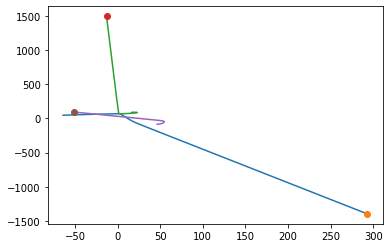

In [490]:
n_body_system.plot()

# Two-Body-Problem

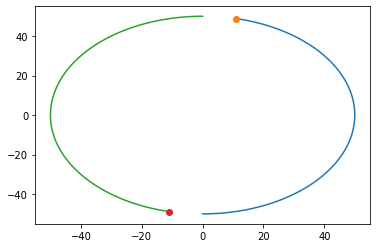

In [310]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([-R, R])

V = (n_body_system.G * n_body_system.n_mass[0] / (4 * R)) ** 0.5
n_body_system.init_vx = np.array([V, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(8000)

n_body_system.plot()

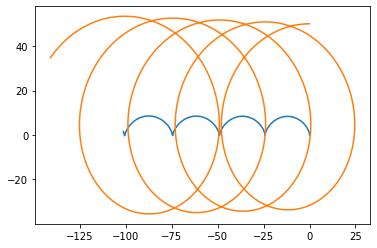

In [299]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([0, R])

n_body_system.n_mass[0] = n_body_system.n_mass[1] * 10

V = (n_body_system.G * n_body_system.n_mass[0] / R) ** 0.5
n_body_system.init_vx = np.array([0, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(10000)

n_body_system.plot()

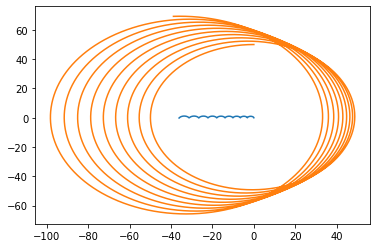

In [300]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([0, R])

n_body_system.n_mass[0] = n_body_system.n_mass[1] * 100

V = (n_body_system.G * n_body_system.n_mass[0] / R) ** 0.5
n_body_system.init_vx = np.array([0, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(10000)

n_body_system.plot()

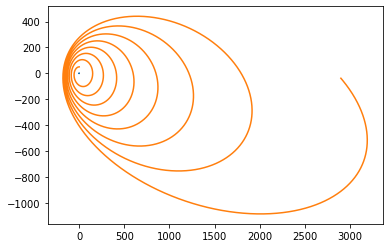

In [303]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([0, R])

n_body_system.n_mass[0] = n_body_system.n_mass[1] * 100000

V = (n_body_system.G * n_body_system.n_mass[0] / R) ** 0.5
n_body_system.init_vx = np.array([0, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(10000)

n_body_system.plot()

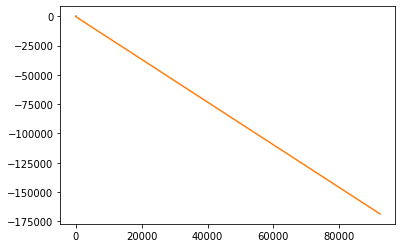

In [304]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([0, R])

n_body_system.n_mass[0] = n_body_system.n_mass[1] * 1000000

V = (n_body_system.G * n_body_system.n_mass[0] / R) ** 0.5
n_body_system.init_vx = np.array([0, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(10000)

n_body_system.plot()

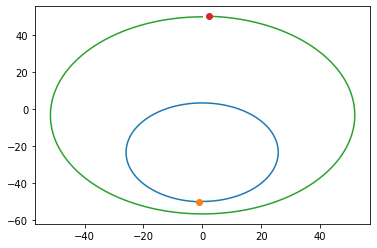

In [7]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([-R, R])

n_body_system.n_mass[0] = n_body_system.n_mass[1] * 2

V = (n_body_system.G * n_body_system.n_mass[0] / R / 4) ** 0.5
n_body_system.init_vx = np.array([V/2, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(10000)

n_body_system.plot()

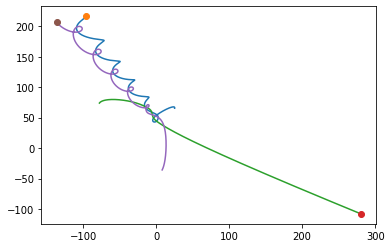

In [123]:
n_body_system = N_Body_System(3)

n_body_system.play(10000)

n_body_system.plot()

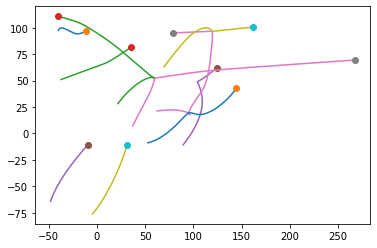

In [10]:
n_body_system = N_Body_System(10)

n_body_system.n_mass = n_body_system.n_mass * 0.01

n_body_system.play(10000)

n_body_system.plot()

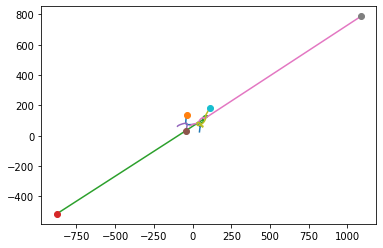

In [31]:
n_body_system = N_Body_System(5)

n_body_system.n_mass = n_body_system.n_mass * 0.1

n_body_system.play(10000)

n_body_system.plot()